# Material for Chapter 6: Lifts

* This notebooks include some code used in Chapter 6.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {
        'titlesize' : 22,
        'labelsize' : 20}
matplotlib.rc('font', **font)  # pass in the font dict as kwargs
matplotlib.rc('axes', **axes)  # pass in the font dict as kwargs


### Lifts in classifiers

In [65]:
def balance_data(ydf, xdf, sampling_method):
    '''
    Function to balance a dataset by under or oversampling
    Inputs:
        ydf: Y: usually Ytrain
        xdf: X: usually Xtrain
        sampling_method: ['over','under']
    Output:
        Balanced versions of y and x
    '''
    # find minority class: if mean < 0.5 -> minority class = 1
    min_class = 1*(ydf.mean() < 0.5)
    # get indices for classes
    loc_min = ydf == min_class
    min_ix = ydf[loc_min].index
    max_ix = ydf[loc_min==False].index
    n_min = len(min_ix)
    n_max = len(max_ix)
    if sampling_method == 'over':
        num_sml = n_max//n_min
        sml_ix = np.random.choice(min_ix, size = n_max, replace = True)
        sml_all = np.concatenate((sml_ix, max_ix),axis = 0)
    elif sampling_method == 'under':
        sml_ix = np.random.choice(max_ix, size = n_min, replace = True)
        sml_all = np.concatenate((sml_ix, min_ix),axis = 0)
    # ready to assemble everything
    y_new = ydf.loc[sml_all]
    x_new = xdf.loc[sml_all]
    return y_new, x_new

In [85]:
np.random.seed(2145)
N = 1000
# simple model: z = 0.5 + 10*x + epsilon
# X ~ N(0,1)
# epsilon ~N(0,0.5)
var1 = 1
var2 = 10
var_epsilon = 10
x1 = np.sqrt(var1)*np.random.normal(size = N)
x2 = np.sqrt(var2)*np.random.normal(size = N)
epsilon = np.sqrt(var_epsilon)*np.random.normal(size=N)
z = 0.5 - 15*x1 + 7*x2 + epsilon
thresh = np.quantile(z, 0.25)
y = 1*(z < thresh)
df = pd.DataFrame(y, columns = ['y'])

In [86]:
# train a simple classifier: Logistic regression
# I will exclude one of the features on purpose
df_x = pd.DataFrame(x1, columns = ['x1'])
X_train, X_test, y_train, y_test = train_test_split(df_x, df, test_size=0.2, random_state=2127)
# balance y_train, X_train
y_bal, x_bal = balance_data(df.y, df_x, sampling_method = 'over')
print(f'Sample mean of balanced y = {y_bal.mean()}')

Sample mean of balanced y = 0.5


In [87]:
# train logistic regression
clf = LogisticRegression(random_state=0).fit(x_bal, y_bal)
# predict in test
df_score = pd.DataFrame(clf.predict_proba(X_test)[:,1], columns = ['score'], index = X_test.index)
# get deciles
deciles = pd.qcut(df_score.score, q = np.linspace(0,1,11))
edges = deciles.apply(lambda x: x.left)
decile_dic = {cat:i for i,cat in enumerate(np.sort(edges.unique()))}
deciles_cats = edges.replace(decile_dic)
df_score['deciles'] = deciles_cats
df_score['y_test'] = y_test

In [88]:
# plot true positive rate (churn rate by decile)
churn_df = pd.DataFrame(df_score.y_test.groupby(df_score.deciles).mean())
churn_df.rename(columns = {'y_test':'churn_deciles'}, inplace = True)
avg_churn = df_score.y_test.mean()
churn_df['lift'] = churn_df.churn_deciles/avg_churn
churn_df

,churn_deciles,lift
deciles,,
0,0.05,0.181818
1,0.10,0.363636
2,0.10,0.363636
3,0.20,0.727273
4,0.15,0.545455
5,0.15,0.545455
6,0.25,0.909091
7,0.40,1.454545
8,0.60,2.181818


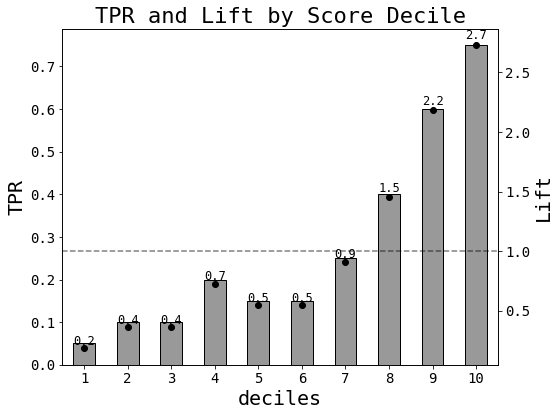

In [113]:
fig, ax = plt.subplots(figsize = (8,6))
churn_df.churn_deciles.plot(ax = ax, kind = 'bar', color = '0.6', edgecolor = 'k')
ax.set_xticklabels(range(1,11), rotation = 0)
ax.set_title('TPR and Lift by Score Decile')
ax.set_ylabel('TPR')
# now plot Lifts on secondary axis
ax1 = ax.twinx()
ax1.set_ylabel('Lift')
ax1.scatter(churn_df.index, churn_df.lift, color = 'k')
for i, ind in enumerate(churn_df.index):
    y_i = churn_df.lift.loc[ind]
    str_lft = np.around(y_i, decimals = 1)
    ax1.text(ind, 1.01*y_i, str_lft, fontsize = 12,
             horizontalalignment = 'center', verticalalignment = 'bottom')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax1.get_xlim()
ax1.plot([xmin, xmax], [1,1], ls = '--', color = 'k', alpha = 0.5)
fig.tight_layout()
print('')

# Selection and Survival Bias

In [192]:
# let's create a simulated example of features for the churn model
np.random.seed(2022)
size = 100
x1 = 10*np.random.beta(a = 0.5, b =1 , size = size)
x2 = 10 + np.random.normal(size = size)
x3 = 1000*np.random.uniform(low = 1, high = 100, size = size)
x4 = 100*np.random.beta(a = 5, b = 0.5, size = size)
noise = np.random.normal(size=size)
pre_y = 5 - 0.3*x1 + 7*x2 + 5*x3 - 50000*x4+ noise 
thresh = np.quantile(pre_y, 0.5)
y = 1*(pre_y > thresh)
churn_rate = 100*np.mean(y)
print(f'% of users that churn = {churn_rate}%')

# let's have everything in a DF
df = pd.DataFrame(y, columns = ['y'])
df['Monthly spend'] = x1
df['Customer satisfaction score'] = x2
df['Income'] = x3
df['Tenure'] = x4
df.head()

% of users that churn = 50.0%


,y,Monthly spend,Customer satisfaction score,Income,Tenure
0,0,0.001755,9.530760,89681.521323,99.853734
1,1,2.046138,10.379185,83927.005339,65.770390
2,0,4.910091,10.350077,43982.043159,96.912565
3,1,2.149102,9.980432,43055.896291,93.997718
4,1,1.568903,11.083620,46213.023900,65.982417


In [196]:
cols = ['Monthly spend', 'Customer satisfaction score', 'Income','Tenure']
mean_df = df[cols].groupby(df.y).mean().T
mean_df['Lift'] = mean_df[1]/mean_df[0]
mean_df.rename(columns = {0:'All', 1: 'Churned'}, inplace = True)
mean_df.round(decimals = 2)

y,All,Churned,Lift
Monthly spend,2.99,3.27,1.10
Customer satisfaction score,10.00,10.08,1.01
Income,46521.26,54804.56,1.18
Tenure,98.48,81.44,0.83


In [198]:
df[cols].mean()

Monthly spend                      3.130616
Customer satisfaction score       10.039256
Income                         50662.911837
Tenure                            89.958937
dtype: float64